### Ejercicio 1

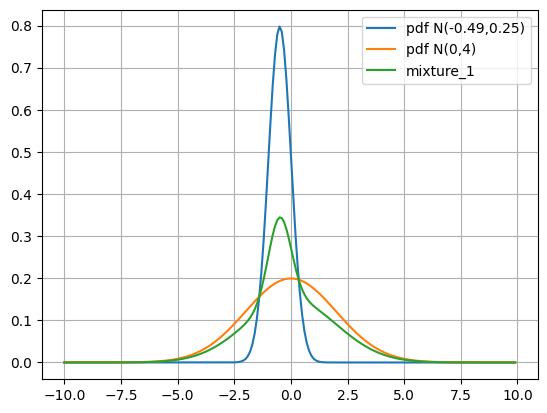

,datos,phi_1,phi_2,mixture_1
0,-10.0,2.221607e-79,7.433598e-07,5.575198e-07
1,-9.9,9.773219e-78,9.533005e-07,7.149753e-07
2,-9.8,4.130819e-76,1.219480e-06,9.146103e-07
3,-9.7,1.677502e-74,1.556088e-06,1.167066e-06
4,-9.6,6.545125e-73,1.980650e-06,1.485487e-06


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import sys
import os
from scipy.stats import norm
from scipy.stats import kurtosis, skew

w1=0.25
w2=0.75
mu1=-0.49
mu2=0
varianza_1=0.49
varianza_2=4

datos=np.arange(start=-10,stop=10,step=0.1)
df_datos=pd.DataFrame(datos,columns=['datos'])


#df_datos['phi_1']=df_datos['datos'].apply(funcion_normal,media=-1,varianza=9)
#df_datos['phi_2']=df_datos['datos'].apply(funcion_normal,media=-1,varianza=4)
#df_datos['mixture_1']=df_datos['datos'].apply(funcion_densidad_mixture,media_1=-1,varianza_1=9,media_2=-1,varianza_2=4,peso_1=.4,peso_2=.6)

df_datos['phi_1']=norm.pdf(loc=mu1,scale=np.sqrt(varianza_1),x=df_datos['datos'])
df_datos['phi_2']=norm.pdf(loc=mu2,scale=np.sqrt(varianza_2),x=df_datos['datos'])


df_datos['mixture_1']=w1*df_datos['phi_1']+w2*df_datos['phi_2']

plt.figure()
plt.plot(df_datos['datos'],df_datos['phi_1'],label='pdf N(-0.49,0.49)')
plt.plot(df_datos['datos'],df_datos['phi_2'],label='pdf N(0,4)')
plt.plot(df_datos['datos'],df_datos['mixture_1'],label='mixture_1')
plt.legend()
plt.grid()
plt.show()

df_datos.head()

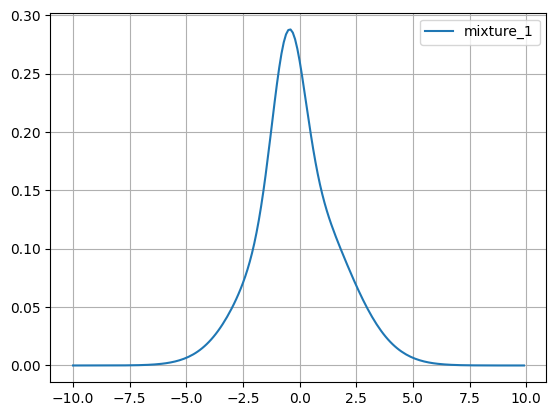

In [3]:
plt.figure()

plt.plot(df_datos['datos'],df_datos['mixture_1'],label='mixture_1')
plt.legend()
plt.grid()
plt.show()

### La mixtura se ve ligeramente asimétrica positiva en el grafico pero no super evidente
Esto es esperable dado que la distribucion no es equitativa de los valores y eso tiene impacto en la simetría

### 3 Calculamos las estadísticas

In [4]:
# Normalización (por si acaso)
dx = 0.1
mixture = df_datos['mixture_1'].values  # Use the mixture density from the grid
x = datos
area = np.sum(mixture * dx)
# Media
mu = np.sum(x * mixture * dx) / area

# Varianza
var = np.sum((x - mu)**2 * mixture * dx) / area
std = np.sqrt(var)

# Asimetría (skewness)
skewness = np.sum(((x - mu)**3) * mixture * dx) / (area * std**3)

# Curtosis
kurt = np.sum(((x - mu)**4) * mixture * dx) / (area * std**4)
kurt_excess = kurt - 3

# Resultados
print(f"Media: {mu:.4f}")
print(f"Varianza: {var:.4f}")
print(f"Asimetría: {skewness:.4f}")
print(f"Curtosis: {kurt:.4f}")
print(f"Curtosis en exceso: {kurt_excess:.4f}")

Media: -0.1225
Varianza: 3.1675
Asimetría: 0.1696
Curtosis: 3.6429
Curtosis en exceso: 0.6429


### Es leptocurtica?
Rta: tiene curtosis en exeso por lo tanto es leptocurtica

### Generar 2000 valores aleatorios de la mezcla y graficamos qqplot

In [16]:
n = 2000
n19 = np.random.normal(mu1,np.sqrt(varianza_1),size=n)
n14 = np.random.normal(mu2,np.sqrt(varianza_2),size=n)
u01 = np.random.uniform(size=n)
bootstrap_mxt = np.where(u01 < w1, n19,n14)

promedio = bootstrap_mxt.mean()
desvio_std = bootstrap_mxt.std()
ke = stats.kurtosis(bootstrap_mxt)
asimetria = stats.skew(bootstrap_mxt)

boostrap_estandar = np.sort((bootstrap_mxt - promedio) / desvio_std)

print(f'Promedio: {promedio}')
print(f'Desvío std: {desvio_std}')
print(f'Asimetría: {asimetria}')
print(f'curtosis en exceso: {ke}')

df_bootstrap = pd.DataFrame({'N(-1,9)': n19, 'N(-1,4)':n14, 'U[0,1]':u01, 'Bootstrap de Mixtura':bootstrap_mxt})
df_bootstrap.head(8)

Promedio: -0.13707835119788414
Desvío std: 1.838555503561703
Asimetría: 0.24449178469813343
curtosis en exceso: 0.7778572360383902


,"N(-1,9)","N(-1,4)","U[0,1]",Bootstrap de Mixtura
0,-1.416171,-3.276374,0.836471,-3.276374
1,-0.014834,-0.995141,0.351107,-0.995141
2,-0.555177,0.214475,0.741776,0.214475
3,0.140229,4.454820,0.411806,4.454820
4,-1.666536,1.283567,0.562870,1.283567
5,-0.657244,-1.423170,0.398265,-1.423170
6,0.006720,0.388178,0.537741,0.388178
7,-0.497938,0.862881,0.032025,-0.497938


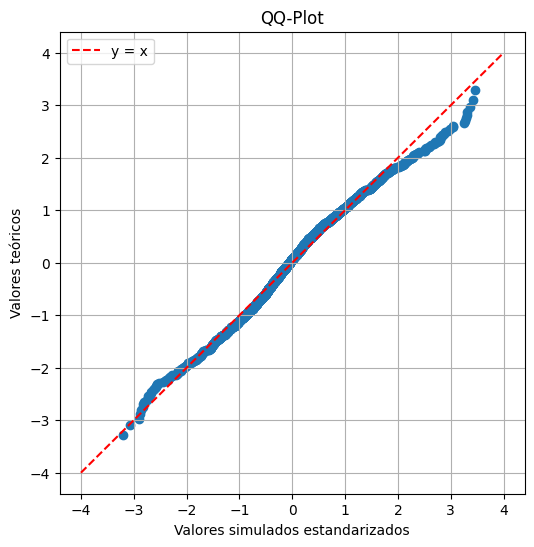

In [17]:
cuantiles_teoricos = stats.norm.ppf(np.arange(1,n+1)/n)
plt.figure(figsize=(6,6))
plt.scatter(boostrap_estandar, cuantiles_teoricos)
plt.plot([-4, 4], [-4, 4], 'r--', label="y = x")
plt.xlabel("Valores simulados estandarizados")
plt.ylabel("Valores teóricos")
plt.title("QQ-Plot")
plt.grid(True)
plt.legend()
plt.show()

# Ejercicio 2

In [28]:
import pandas as pd
import numpy as np
from arch.unitroot import DFGLS
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


In [32]:

from statsmodels.tsa.stattools import adfuller 
def test_dickey_fuller(series):
    """Realiza la prueba de Dickey-Fuller aumentado."""
    result = adfuller(series, autolag='AIC')
    print(f'Estadístico ADF: {result[0]}')
    print(f'Valor p: {result[1]}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'  {key}: {value}')




In [25]:
df = pd.read_stata("base.dta")


In [26]:
df.set_index("t")
df

,RBER_AR,RBER_AR_sd6,t
0,98.870003,1.225477,2010-01-01
1,100.620003,1.976474,2010-02-01
2,99.820000,2.138749,2010-03-01
3,99.349998,1.786254,2010-04-01
4,102.059998,1.618118,2010-05-01
...,...,...,...
127,55.080002,1.556141,2020-08-01
128,54.680000,1.686558,2020-09-01
129,55.209999,1.371647,2020-10-01
130,54.009998,0.627867,2020-11-01


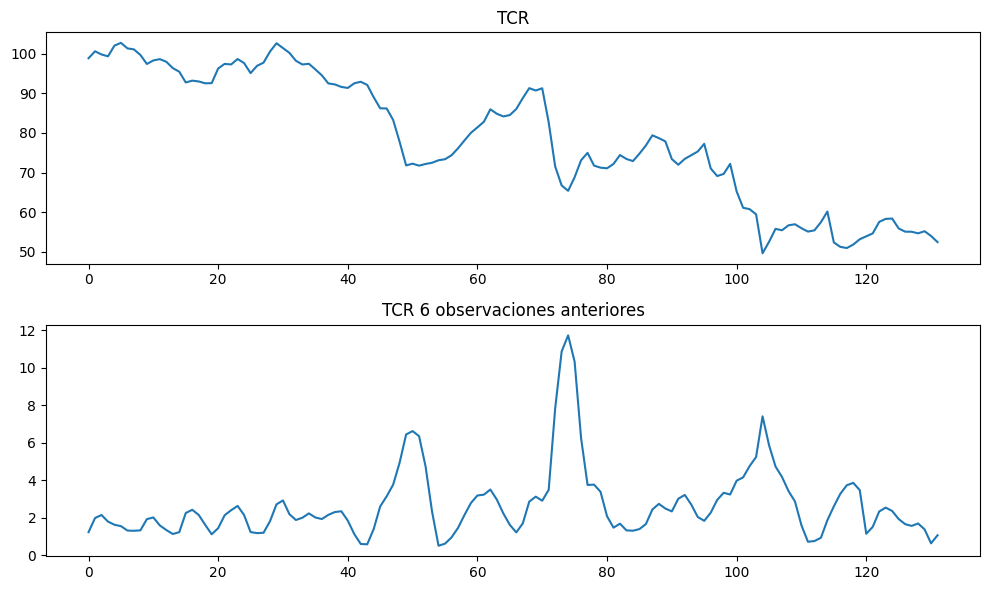

In [27]:
##Ploteamos la series
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
df["RBER_AR"].plot(ax=ax[0], title="TCR")
df["RBER_AR_sd6"].plot(ax=ax[1], title="TCR 6 observaciones anteriores")
plt.tight_layout()
plt.show() 


### Vemos el orden de integracion

In [41]:

print("DFGLS TC:\n", DFGLS(df["RBER_AR"].dropna(),trend='ct').summary())
print("DFGLS TC-6 observaciones:\n", DFGLS(df["RBER_AR_sd6"].dropna()).summary())

DFGLS TC:
       Dickey-Fuller GLS Results      
Test Statistic                 -3.470
P-value                         0.009
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.57 (1%), -2.99 (5%), -2.70 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
DFGLS TC-6 observaciones:
       Dickey-Fuller GLS Results      
Test Statistic                 -3.505
P-value                         0.001
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -2.72 (1%), -2.10 (5%), -1.78 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Segun DFGLS para el regago 1 RH0 por lo tanto es estacionaria, pero sigo viendo que tiene una tendencia, parece que el test no la captura, corro un test de ADF con un rezago a ver que pasa

In [49]:
adf_test_1 = adfuller(df["RBER_AR"].dropna(), maxlag=1, regression="ct", autolag=None)
print("ADF lags=1 trend:", adf_test_1)
print("ADF lags=1 trend estadistico:", adf_test_1[0])
print("ADF lags=1 trend p-value:", adf_test_1[1])
print("ADF LAGS: ", adf_test_1[2])
print("ADF observaciones:", adf_test_1[3])
print("ADF lags=8 trend criticos:", adf_test_1[4])

ADF lags=1 trend: (-3.7043618301512558, 0.022071616204800873, 1, 130, {'1%': -4.030152423759672, '5%': -3.444817634956759, '10%': -3.1471816659080565})
ADF lags=1 trend estadistico: -3.7043618301512558
ADF lags=1 trend p-value: 0.022071616204800873
ADF LAGS:  1
ADF observaciones: 130
ADF lags=8 trend criticos: {'1%': -4.030152423759672, '5%': -3.444817634956759, '10%': -3.1471816659080565}


### Me dice que es significativo al 5%

In [52]:
adf_test_2 = adfuller(df["RBER_AR"].dropna(), maxlag=1, regression="c", autolag=None)
print("ADF lags=1 trend:", adf_test_2)
print("ADF lags=1 trend estadistico:", adf_test_2[0])
print("ADF lags=1 trend p-value:", adf_test_2[1])
print("ADF LAGS: ", adf_test_2[2])
print("ADF observaciones:", adf_test_2[3])
print("ADF lags=8 trend criticos:", adf_test_2[4])

ADF lags=1 trend: (-1.155684484232061, 0.6923629260886708, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598})
ADF lags=1 trend estadistico: -1.155684484232061
ADF lags=1 trend p-value: 0.6923629260886708
ADF LAGS:  1
ADF observaciones: 130
ADF lags=8 trend criticos: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


### Aca se puede ver que es NO estacionaria, lo que implica que en realidad es estacionaria sobre la tendencia deterministica. 
### Entonces es NO estacionaria en nivel, pero si sobre una tendencia determinística, es del tipo $ y_t=α+βt+u $
### En resumen la serie es I(0) con tendencia determinísitica. No incluir la tendencia en el test es un error de especificiación. Según la bilbio hay que incluir la tendencia en los regresores VAR

In [54]:
## corremos el test para ver si la tendencia es significativa como intuimos

y = df["RBER_AR"].dropna().astype(float)

# 1) corre ADF para saber cuántos lags usó (autolag AIC en este ejemplo)
adf_stat, pval, k_lags, nobs, crit, icbest = adfuller(y, regression="ct", autolag="AIC")
print("ADF stat:", adf_stat, "p-val:", pval, "lags:", k_lags)

# 2) construí la regresión ADF equivalente
T = len(y)
t = np.arange(1, T+1) # tendencia lineal
dy = y.diff()

X = pd.DataFrame({
    "const": 1.0,
    "trend": t,
    "y_lag1": y.shift(1),
    })

# agrega Δy_{t-i}, i=1..k
for i in range(1, k_lags+1):
    X[f"dy_lag{i}"] = dy.shift(i)

# variable dependiente: Δy_t
Y = dy

# 3) alineá y ajustá OLS
data = pd.concat([Y, X], axis=1).dropna()
Y_ols = data.iloc[:, 0]
X_ols = data.iloc[:, 1:]

res = sm.OLS(Y_ols, X_ols).fit()
print(res.summary())



ADF stat: -3.7043618301512558 p-val: 0.022071616204800873 lags: 1
                            OLS Regression Results                            
Dep. Variable:                RBER_AR   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     10.19
Date:                Sat, 30 Aug 2025   Prob (F-statistic):           4.69e-06
Time:                        01:17:27   Log-Likelihood:                -293.33
No. Observations:                 130   AIC:                             594.7
Df Residuals:                     126   BIC:                             606.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

### Concluimos que RBER_AR es I(0) con tendencia determinística. Es no estacionaria en nivel pero si en tendencia

## Ahora vamos con "RBER_AR_sd6"

In [57]:
print("DFGLS TC-6 observaciones:\n", DFGLS(df["RBER_AR_sd6"].dropna(),trend='ct').summary())

DFGLS TC-6 observaciones:
       Dickey-Fuller GLS Results      
Test Statistic                 -4.237
P-value                         0.001
Lags                                2
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.57 (1%), -2.99 (5%), -2.70 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Esta parece ser ya I(0) de entrada

In [58]:
adf_test_RBER_AR_sd6 = adfuller(df["RBER_AR_sd6"].dropna(), maxlag=2, regression="ct", autolag=None)
print("ADF lags=1 trend:", adf_test_RBER_AR_sd6)
print("ADF lags=1 trend estadistico:", adf_test_RBER_AR_sd6[0])
print("ADF lags=1 trend p-value:", adf_test_RBER_AR_sd6[1])
print("ADF LAGS: ", adf_test_RBER_AR_sd6[2])
print("ADF observaciones:", adf_test_RBER_AR_sd6[3])
print("ADF lags=8 trend criticos:", adf_test_RBER_AR_sd6[4])

ADF lags=1 trend: (-4.323133205419155, 0.002895753551653172, 2, 129, {'1%': -4.030719874481119, '5%': -3.4450882414779223, '10%': -3.1473396994394625})
ADF lags=1 trend estadistico: -4.323133205419155
ADF lags=1 trend p-value: 0.002895753551653172
ADF LAGS:  2
ADF observaciones: 129
ADF lags=8 trend criticos: {'1%': -4.030719874481119, '5%': -3.4450882414779223, '10%': -3.1473396994394625}


Es significativo al 1% por lo tanto es I(0)

# Ahora removemos la tendencia determinisitca de la preimer serie y calculamos el modelo VAR

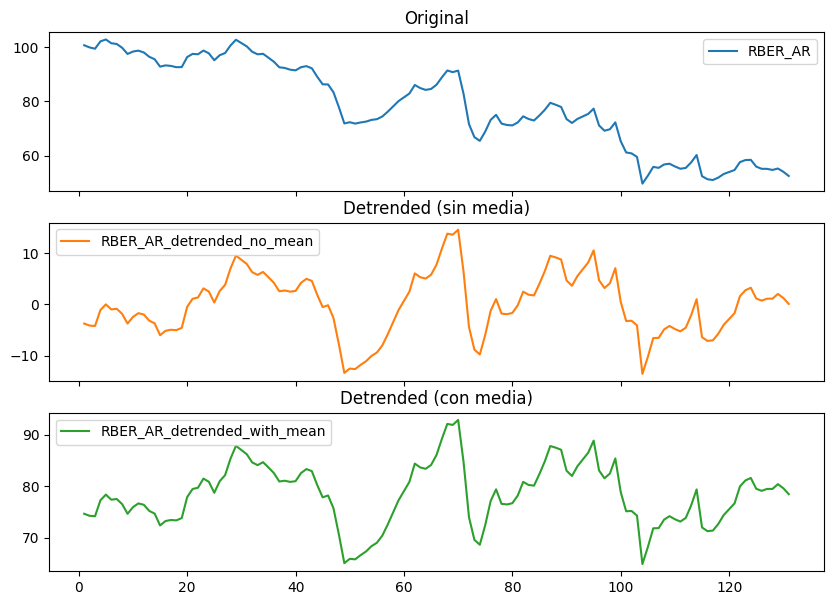

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Serie original (sin NaN)
serie = df['RBER_AR'].dropna()

# --- 1) Detrend puro (quita pendiente + constante)
detr = signal.detrend(serie.to_numpy(), type='linear')

# --- 2) Detrend + media original (quita solo pendiente, mantiene el nivel)
detr_with_mean = detr + serie.mean()

# Guardar en el DataFrame
df.loc[serie.index, 'RBER_AR_detrended_no_mean'] = detr
df.loc[serie.index, 'RBER_AR_detrended_with_mean'] = detr_with_mean

# --- Graficar para comparar ---
df.loc[serie.index, ['RBER_AR',
                     'RBER_AR_detrended_no_mean',
                     'RBER_AR_detrended_with_mean']].plot(subplots=True,
                                                         figsize=(10,7),
                                                         title=["Original",
                                                                "Detrended (sin media)",
                                                                "Detrended (con media)"])
plt.show()


Da igual usar la que esta centrada y la que no, no se pierde informacion

In [74]:
data = df[["RBER_AR_detrended_with_mean", "RBER_AR_sd6"]].dropna()  # Es bivariado porque tiene dos variables

# VAR(2)
model=VAR(data)
var2_1 = model.fit(maxlags=2)
print(var2_1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Aug, 2025
Time:                     02:22:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.06149
Nobs:                     129.000    HQIC:                  0.929876
Log likelihood:          -410.253    FPE:                    2.31608
AIC:                     0.839799    Det(Omega_mle):         2.14646
--------------------------------------------------------------------
Results for equation RBER_AR_detrended_with_mean
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 11.343996         3.199215            3.546           0.000
L1.RBER_AR_detrended_with_mean         1.254308         0.094176    

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [70]:
print(model.select_order().summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.825       4.872       124.6       4.844
1        1.600       1.741       4.954       1.657
2      0.9700*      1.205*      2.638*      1.065*
3       0.9764       1.305       2.656       1.110
4        1.021       1.444       2.778       1.193
5        1.082       1.598       2.953       1.291
6        1.067       1.678       2.913       1.315
7        1.020       1.725       2.782       1.306
8        1.054       1.853       2.882       1.379
9        1.038       1.930       2.840       1.400
10       1.068       2.055       2.933       1.469
11       1.101       2.181       3.038       1.540
12       1.033       2.207       2.845       1.509
13       1.079       2.347       2.992       1.594
--------------------------------------------------


In [76]:
# Estabilidad del VAR: raíces dentro del círculo unitario
print("Raíces del VAR(2):", var2_1.roots)
print("¿Estable?", np.all(np.abs(var2_1.roots) > 1))

Raíces del VAR(2): [1.53830073+0.60082011j 1.53830073-0.60082011j 1.26451342+0.36702957j
 1.26451342-0.36702957j]
¿Estable? True


Los vars son estables

### Ahora hacemos un test de Granger para ver causalidad

In [78]:
### hacemos un test de Granger para ver causalidad
granger_test = var2_1.test_causality('RBER_AR_detrended_with_mean', ['RBER_AR_sd6'], kind='f')
print(granger_test.summary())
#!/usr/bin/env python3

granger_test = var2_1.test_causality('RBER_AR_sd6', ['RBER_AR_detrended_with_mean'], kind='f')
print(granger_test.summary())

Granger causality F-test. H_0: RBER_AR_sd6 does not Granger-cause RBER_AR_detrended_with_mean. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.1592          3.032   0.853 (2, 248)
----------------------------------------------
Granger causality F-test. H_0: RBER_AR_detrended_with_mean does not Granger-cause RBER_AR_sd6. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         4.879          3.032   0.008 (2, 248)
----------------------------------------------


Aca nos dice que los regagos de RBER_AR_detrended_with_mean nos da informacion estadística para predecir RBER_AR_sd6 en el sentido de Granger.


Hipótesis nula (H₀): “X no Granger-causa a Y” → es decir, los rezagos de X no aportan información útil para predecir Y.

Hipótesis alternativa (H₁): “X sí Granger-causa a Y” → los rezagos de X ayudan a explicar/predicen Y más allá de lo que Y explica con sus propios rezagos.



El test entregó un p-valor < 0.05, por eso se rechaza H₀ al 5%.

En consecuencia, la serie X (RBER_AR_detrended_with_mean) ayuda a predecir la serie Y (RBER_AR_sd6) en el marco de este modelo VAR.

Ojo: esto significa capacidad predictiva estadística, no causalidad estructural/económica.




# Ejercicio 3

In [80]:
from scipy.stats import norm
def generar_ruido_blanco(tamano):
    """Genera una serie de tiempo de ruido blanco."""
    return np.random.normal(loc=0, scale=1, size=tamano)

def generarRuidoBlancoPPf(tamano):
    return norm.ppf(np.random.rand(tamano))

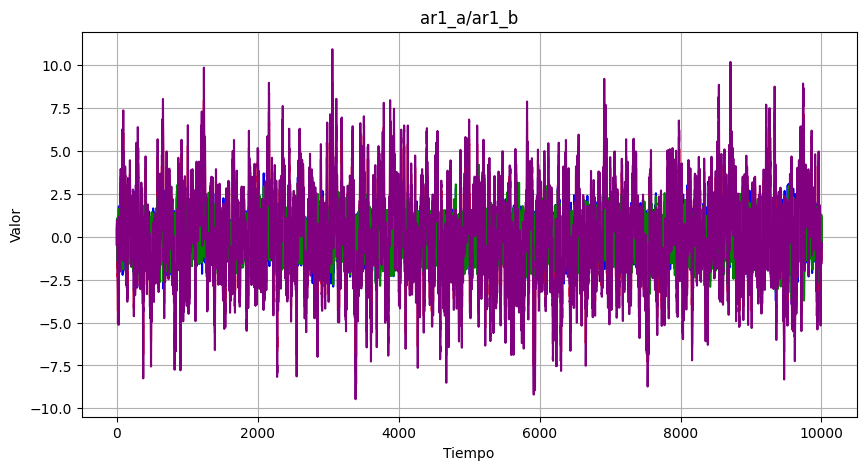

In [94]:
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import lfilter

df=pd.DataFrame(generarRuidoBlancoPPf(10000),columns=['ruido_blanco'])
rho_1=0.5
rho_2=0.9
#
df['ar1_a']=lfilter([1],[1,-rho_1],df['ruido_blanco'])
df['ar1_b']=lfilter([1],[1,-rho_2],df['ruido_blanco'])
df['ar2_a'] = lfilter([1], [1, -1.1, 0.18], df['ruido_blanco'])  # los coeficientes van con signo cambiado son 1.1 y -0.18 en realidad


plt.figure(figsize=(10, 5))
plt.plot(df['ar1_a'], color='blue')
plt.plot(df['ar1_b'], color='red')
plt.plot(df['ruido_blanco'],color='green')
plt.plot(df['ar2_a'], color='purple')
plt.title('ar1_a/ar1_b')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid()
plt.show()


### Quiero ver si es AR(2), debilmente estacionario

In [95]:
print("DFGLS ar2_a:\n", DFGLS(df['ar2_a'].dropna(),trend='ct').summary())

DFGLS ar2_a:
       Dickey-Fuller GLS Results      
Test Statistic                -22.292
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.41 (1%), -2.85 (5%), -2.56 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### El proceso parece ES estacionario, el p value es significagtivo.

In [96]:
adf_test_ar2_a = adfuller(df["ar2_a"].dropna(), maxlag=2, regression="ct", autolag=None)
print("ADF lags=1 trend:", adf_test_ar2_a)
print("ADF lags=1 trend estadistico:", adf_test_ar2_a[0])
print("ADF lags=1 trend p-value:", adf_test_ar2_a[1])
print("ADF LAGS: ", adf_test_ar2_a[2])
print("ADF observaciones:", adf_test_ar2_a[3])
print("ADF lags=8 trend criticos:", adf_test_ar2_a[4])

ADF lags=1 trend: (-22.131198553796597, 0.0, 2, 9997, {'1%': -3.9596758662594227, '5%': -3.4109292622111806, '10%': -3.1273086768872385})
ADF lags=1 trend estadistico: -22.131198553796597
ADF lags=1 trend p-value: 0.0
ADF LAGS:  2
ADF observaciones: 9997
ADF lags=8 trend criticos: {'1%': -3.9596758662594227, '5%': -3.4109292622111806, '10%': -3.1273086768872385}


ES estacionario.
Vemos si es un AR(2)

Hay otra forma de ver si es estacionario que es tomar las raices

In [98]:
import numpy as np

# AR(2): y_t = 1.1 y_{t-1} - 0.18 y_{t-2} + e_t
phi1, phi2 = 1.1, -0.18

# 1 - phi1 z - phi2 z^2 = 0  →  coeficientes [ -phi2, -phi1, 1 ]
coefs = [ -phi2, -phi1, 1 ]   # [0.18, -1.1, 1]
roots = np.roots(coefs)

print("Raíces:", roots)
print("Módulos:", np.abs(roots))
print("Estacionario?:", np.all(np.abs(roots) > 1))

Raíces: [5.         1.11111111]
Módulos: [5.         1.11111111]
Estacionario?: True


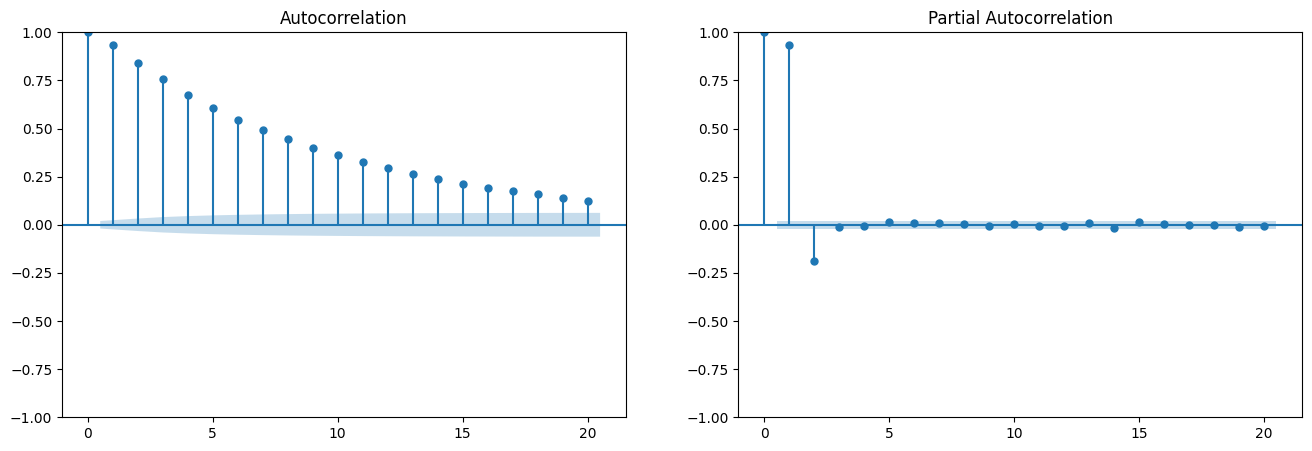

In [97]:
def plot_acf_pacf(series, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    plt.show()
plot_acf_pacf(df['ar2_a'].dropna(), lags=20)

Ahora se ve claro que es un AR(2).

El patrón de la ACF (decaimiento lento y exponencial) es característico de un AR(p).

La PACF con un corte claro en el primer rezago (lag 1) es típico de un AR(1).

En contraste, un MA(q) mostraría lo opuesto: la ACF se “corta” en q y la PACF decae gradualmente.

## Ejercicio 4